In [1]:
import os
import numpy as np
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from collections import Counter
from tqdm import tqdm
sns.set_theme(style="white")
plt.figure(figsize=(10, 8))
colors = ['#66c2a5', '#fc8d62']


plt.rcParams.update({
    'font.size': 30,
    'axes.labelsize': 30,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'legend.fontsize': 30,
    'axes.titlesize': 30
})

task = "aime24"
models = ["qwen3-32b", "qwen3-14b","qwen3-8b","qwen3-4b","qwen3-1-7b"]

<Figure size 1000x800 with 0 Axes>

In [2]:
sparse_method = "topk"
if sparse_method == "topk":
    fname_sign = """_local0_topk{budget}"""
elif sparse_method == "block_topk":
    fname_sign = """_local0_block{block_size}_blocktopk{block_topk}"""
else:
    raise ValueError(f"Invalid sparse method: {sparse_method}")

In [3]:
sparse_points = []
dense_points = []

root_dir = "/home/rsadhukh/ranajoy/sparse_scaling/Kinetics/cost_model"

for model in models:
    if os.path.exists(f"{root_dir}/{task}/dense/{task}_{model}_dense_numTrials_tradeoff.csv"):
        dense_df = pd.read_csv(f"{root_dir}/{task}/dense/{task}_{model}_dense_numTrials_tradeoff.csv")
    else:
        dense_df = None
        
    sparse_df = []
    for budget in [128, 256, 512, 1024, 2048]:
        block_size = 16384 // budget
        block_topk = budget // block_size
        
        if sparse_method == "topk":
            fname = f"{root_dir}/{task}/{sparse_method}/{task}_{model}{fname_sign.format(budget=budget)}_numTrials_tradeoff.csv"
        elif sparse_method == "block_topk":
            fname = f"{root_dir}/{task}/{sparse_method}/{task}_{model}{fname_sign.format(block_size=block_size, block_topk=block_topk)}_numTrials_tradeoff.csv"
        else:
            raise ValueError(f"Invalid sparse method: {sparse_method}")
        
        if os.path.exists(fname):
            sparse_df.append(pd.read_csv(fname))
        else:
            sparse_df.append(None)

    if len(sparse_df) > 0:
        sparse_df = pd.concat(sparse_df)
    else:
        sparse_df = None
    
    min_cost = 4500e-2
    max_cost = 1e5
    cost_points = np.logspace(np.log10(min_cost), np.log10(max_cost), 100)
    
    covs = []
    if dense_df is not None:
        for i, cost in enumerate(cost_points):
            best_covs = []
            for query_id in dense_df["query_id"].unique():
                query_df = dense_df[dense_df["query_id"] == query_id]
                best_coverage = query_df[query_df["total_cost"] <= cost]["coverage"]
                if len(best_coverage) > 0:
                    best_cov = best_coverage.max()
                    best_covs.append(best_cov)
                else:
                    best_covs.append(0)
            covs.append(np.mean(best_covs))
        
        dense_points.append((model, "full", covs, cost_points))
        
    sparse_covs = []
    if sparse_df is not None:
        for i, cost in enumerate(cost_points):
            best_covs = []
            best_ntrials = []
            best_budgets = []
            median_generation_lengths = []
            for query_id in sparse_df["query_id"].unique():
                query_df = sparse_df[sparse_df["query_id"] == query_id]
                best_coverage = query_df[query_df["total_cost"] <= cost]["coverage"]
                if len(best_coverage) > 0:
                    cur_best_cov = best_coverage.max()
                    best_covs.append(cur_best_cov)
                else:
                    best_covs.append(0)
            sparse_covs.append(np.mean(best_covs))
        sparse_points.append((model, "sparse", sparse_covs, cost_points))
        

In [8]:
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib import cm

def get_shades(base_color, n_shades=6, darken_factor=0.4):
    """Return n_shades darker shades of the base_color."""
    base_rgb = np.array(mcolors.to_rgb(base_color))
    dark_rgb = base_rgb * darken_factor  # darker version
    shades = [mcolors.to_hex((1 - alpha) * base_rgb + alpha * dark_rgb)
              for alpha in np.linspace(0, 1, n_shades)]
    return shades

shades_dense = get_shades(colors[1], n_shades=len(models))
shades_sparse = get_shades(colors[0], n_shades=len(models))
shades_sparse = shades_sparse[::-1]
shades_dense = shades_dense[::-1]


<Figure size 640x480 with 0 Axes>

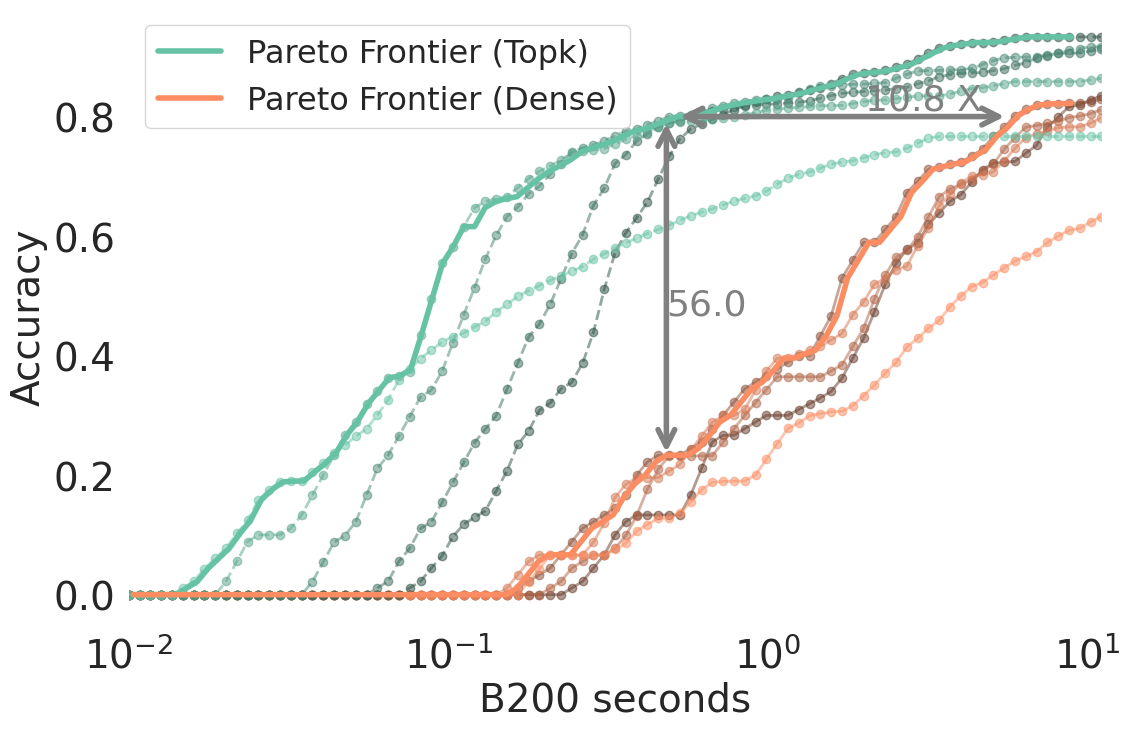

In [9]:
from scipy.ndimage import uniform_filter1d

plt.clf()

fig, ax = plt.subplots(figsize=(12, 8))

model_sizes = {
    "qwen3-32b": 32.76,
    "qwen3-8b": 8.19,
    "qwen3-4b": 4.02,
    "qwen3-14b": 14.33,
    "qwen3-1-7b": 2.03,
    "qwen3-0-6b": 0.752
}

window_size = 3

all_dense_points = []
for (model, label, covs, cost_points), color in zip(dense_points, shades_dense):
    c = np.array(cost_points) / 4500
    smooth_covs = uniform_filter1d(covs, window_size)
    plt.plot(c, smooth_covs, linestyle="-", linewidth=2,alpha=0.5, color=color, marker="o")
    all_dense_points += [(model, p[0], p[1]) for p in zip(smooth_covs, cost_points)]

all_sparse_points = []
for (model, budget, covs, cost_points), color in zip(sparse_points, shades_sparse):
    c = np.array(cost_points) / 4500
    smooth_covs = uniform_filter1d(covs, window_size)
    plt.plot(c, smooth_covs, linestyle="--", linewidth=2,alpha=0.5, color=color, marker="o")
    all_sparse_points += [(model, p[0], p[1]) for p in zip(smooth_covs, cost_points)]

all_sparse_points = sorted(all_sparse_points, key=lambda x: x[0])
all_dense_points = sorted(all_dense_points, key=lambda x: x[0])
all_costs = [p[2] for p in all_sparse_points]
best_model_sizes = []
best_sparse_acc = []
best_dense_acc = []
max_cost = 4e4
min_cost= 20
cost_points = np.logspace(np.log10(min_cost), np.log10(max_cost), 100)
x_data = []
y_data = []
for c in cost_points:
    valid_points = [p for p in all_sparse_points if  p[2] <= c]
    if not valid_points:
        best_model_sizes.append(None)
        continue
    best_point = max(valid_points, key=lambda x: x[1])
    best_sparse_acc.append(best_point[1])
    best_model_sizes.append(model_sizes[best_point[0]])
    x_data.append(c)

for c in cost_points:
    valid_points = [p for p in all_dense_points if  p[2] <= c]
    if not valid_points:
        continue
    best_point = max(valid_points, key=lambda x: x[1])
    best_dense_acc.append(best_point[1])
    y_data.append(c)

x_data = np.array(x_data) / 4500
y_data = np.array(y_data) / 4500
plt.plot(x_data, best_sparse_acc, label=f"Pareto Frontier (Topk)", linewidth=4, color=colors[0])
plt.plot(y_data, best_dense_acc, label=f"Pareto Frontier (Dense)", linewidth=4, color=colors[1])

t_thresh = 0.5
acc_thresh = 0.8

x_data_acc_diff = [i for i, p in enumerate(x_data) if p <= t_thresh][-1]
sparse_acc_08 = best_sparse_acc[x_data_acc_diff]
dense_acc_08 = best_dense_acc[x_data_acc_diff]

y_data_time_diff = [i for i, p in enumerate(best_sparse_acc) if p <=acc_thresh][-1]
sparse_time_08 = y_data[y_data_time_diff]
x_data_time_diff = [i for i, p in enumerate(best_dense_acc) if p <=acc_thresh][-1]
dense_time_08 = x_data[x_data_time_diff]

plt.annotate(
    '', 
    xy=(x_data[x_data_acc_diff], best_sparse_acc[x_data_acc_diff]),  
    xytext=(y_data[x_data_acc_diff], best_dense_acc[x_data_acc_diff]),
    arrowprops=dict(arrowstyle='<->', linewidth=4, color='gray')
)

plt.annotate(
    '', 
    xy=(sparse_time_08, acc_thresh),  
    xytext=(dense_time_08, acc_thresh),
    arrowprops=dict(arrowstyle='<->', linewidth=4, color='gray')
)

plt.text(x_data[x_data_acc_diff], 
         (best_sparse_acc[x_data_acc_diff] + best_dense_acc[x_data_acc_diff])/2, 
         f"{(sparse_acc_08 - dense_acc_08)*100:.1f}", 
         ha='left', va='top', fontsize=26, color='gray')

plt.text((sparse_time_08 + dense_time_08)/2, 
         acc_thresh, 
         f"{dense_time_08/sparse_time_08:.1f} X", 
         ha='center', va='bottom', fontsize=26, color='gray')

plt.xscale("log")

plt.xlabel("B200 seconds", fontsize=28)
plt.ylabel("Accuracy", fontsize=28)

plt.legend(loc='upper left', fontsize=23)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlim(0.01, 11)
plt.subplots_adjust(left=0.1, right=0.98, top=0.98, bottom=0.1)
plt.tight_layout()
ax = plt.gca()

for spine in ax.spines.values():
    spine.set_visible(False)

plt.savefig(f"{task}_acc_vs_trials_topk.pdf")

<Figure size 640x480 with 0 Axes>

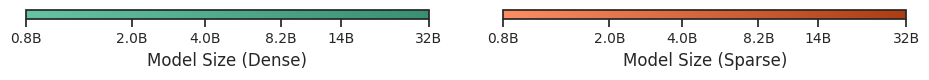

In [6]:
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from matplotlib.colorbar import ColorbarBase

plt.clf()

# Define actual model sizes (in billions)
model_sizes = {
    "qwen3-0-6b": 0.752,
    "qwen3-1-7b": 2.03,
    "qwen3-4b": 4.02,
    "qwen3-8b": 8.19,
    "qwen3-14b": 14.33,
    "qwen3-32b": 32.76,
}

# Define color shades (you can replace these with your actual ones)
shades_dense = ['#66c2a5', '#5db89b', '#54ae91', '#4ba487', '#429a7d', '#398f73']
shades_sparse = ['#fc8d62', '#ec7d52', '#dc6d42', '#cc5d32', '#bc4d22', '#ac3d12']

# Prepare sorted model sizes
sorted_items = sorted(model_sizes.items(), key=lambda x: x[1])
model_labels = [f"{v:.1f}B" if v < 10 else f"{int(v)}B" for _, v in sorted_items]
model_numeric = [v for _, v in sorted_items]

# Create colormaps
cmap_dense = LinearSegmentedColormap.from_list("dense_cmap", shades_dense)
cmap_sparse = LinearSegmentedColormap.from_list("sparse_cmap", shades_sparse)
lognorm = LogNorm(vmin=min(model_numeric), vmax=max(model_numeric))

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(10, 1.5))

# Dense colorbar
cb1 = ColorbarBase(axes[0], cmap=cmap_dense, norm=lognorm, orientation='horizontal')
cb1.set_label('Model Size (Dense)', fontsize=12)
cb1.set_ticks(model_numeric)
cb1.set_ticklabels(model_labels)
cb1.ax.xaxis.set_minor_locator(plt.NullLocator())
cb1.ax.tick_params(labelsize=10)

# Sparse colorbar
cb2 = ColorbarBase(axes[1], cmap=cmap_sparse, norm=lognorm, orientation='horizontal')
cb2.set_label('Model Size (Sparse)', fontsize=12)
cb2.set_ticks(model_numeric)
cb2.set_ticklabels(model_labels)
cb2.ax.xaxis.set_minor_locator(plt.NullLocator())
cb2.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig("model_size_colorbars_log.png", dpi=300, bbox_inches='tight')
plt.savefig("model_size_colorbars_log.svg", bbox_inches='tight')  # optional SVG
plt.show()


